In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch 
import matplotlib.pyplot as plt 
%matplotlib inline
import torchvision 
from torchvision import datasets 
import torchvision.transforms as transforms 

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
import pathlib
%config Completer.use_jedi = False

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# grab data 
test_path = "../input/brain-tumor-classification-mri/Testing"
train_path = "../input/brain-tumor-classification-mri/Training"

# transformations 
transforms1 = transforms.Compose(
[
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
   # transforms.Normalize(mean=[0.1798, 0.1798, 0.1798],
   #                     std=[0.1840, 0.1840, 0.1840])
])

transforms2 = transforms.Compose(
[
    transforms.RandomAutocontrast(),
    transforms.ColorJitter(),
    transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
  #  transforms.Normalize(mean=[0.1798, 0.1798, 0.1798],
  #                      std=[0.1840, 0.1840, 0.1840]) 
])

# download data 
train_data1 = datasets.ImageFolder(train_path, transform=transforms1)
train_data2 = datasets.ImageFolder(train_path, transform=transforms2)
test_data = datasets.ImageFolder(test_path, transform=transforms1)

image_datasets = torch.utils.data.ConcatDataset([train_data1, train_data2])
valid_data, train_data = torch.utils.data.random_split(image_datasets, [740, 5000])

# create data loaders 
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

In [3]:
print(len(train_data))
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()
images.shape

5000


(32, 1, 128, 128)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


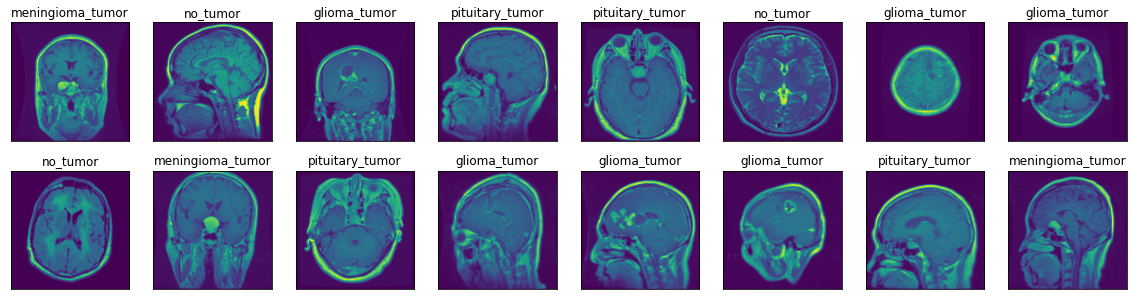

In [4]:
classes = test_loader.dataset.classes
print(classes)

# normalization function 
def imshow(im):
    plt.imshow(np.transpose(im, (1, 2, 0)))

# visualize data 
fig = plt.figure(figsize=(20,5))
for i in range (16):
    ax = fig.add_subplot(2, int(16/2), i+1, xticks=[], yticks=[])
    imshow(images[i])
    ax.set_title(classes[labels[i]])

In [5]:
# convolution network 
class conv_layer(nn.Module):
    def __init__(self, inp, out):
        super(conv_layer, self).__init__()
        self.conv1 = nn.Conv2d(inp, out, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.norm = nn.BatchNorm2d(out)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        
    def forward(self, x):
        x = self.pool(self.norm(self.relu(self.conv1(x))))
        return x
        
# model network 
class network(nn.Module):
    def __init__(self):
        super(network, self).__init__()
        self.input_norm = torch.nn.BatchNorm2d(1, affine=False)
        self.layer1 = conv_layer(inp=1, out=8)
        self.layer2 = conv_layer(inp=8, out=16)
        self.layer3 = conv_layer(inp=16, out=32)
        self.layer4 = conv_layer(inp=32, out=64)
        self.layer5 = conv_layer(inp=64, out=128)
        self.layer6 = conv_layer(inp=128, out=256)
        self.layer7 = conv_layer(inp=256, out=512)
        
        self.net = nn.Sequential(self.layer1, self.layer2, self.layer3, self.layer4, self.layer5, self.layer6, self.layer7)
        
        self.fc1 = torch.nn.Linear(in_features=512, out_features=128)
        self.bn1 = torch.nn.BatchNorm1d(128)
        
        self.fc2 = torch.nn.Linear(in_features=128, out_features=32)
        self.bn2 = torch.nn.BatchNorm1d(32)

        self.fc3 = torch.nn.Linear(in_features=32, out_features=8)
        self.bn3 = torch.nn.BatchNorm1d(8)

        self.fc4 = torch.nn.Linear(in_features=8, out_features=4)
        
        self.lin = torch.nn.Sequential(self.fc1, self.bn1, self.fc2, self.bn2,
                                       self.fc3, self.bn3, self.fc4)  
        
    def forward(self, x):
        x = self.net(x)
        x = x.view(x.size(0), -1)
        x = self.lin(x)
        return x

model = network()
model

network(
  (input_norm): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (layer1): conv_layer(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (norm): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): conv_layer(
    (conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): conv_layer(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1.0E-3)

In [7]:
epochs = 20 
min_loss = 100000

for i in range(epochs): 
    train_loss = 0 
    valid_loss = 0 
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        
        #back prop
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*labels.size(0)


    model.eval()
    for images, labels in valid_loader:
        output = model(images)
        loss = criterion(output, labels)
        valid_loss += loss.item()*labels.size(0)
        
    total_train_loss = train_loss/len(train_loader)
    total_valid_loss = valid_loss/len(valid_loader)
    
    print("\nEpoch {}, \ntraining loss: {} \nvalidation loss: {}".format(i, total_train_loss, total_valid_loss))
    if total_valid_loss < min_loss: 
        print("loss decreased {} --> {}".format(min_loss, total_valid_loss))
        torch.save(model.state_dict(), 'model.brain.pt')
        min_loss = total_valid_loss
        
print("Congrats, training complete 🎉")


Epoch 0, 
training loss: 22.26457895594797 
validation loss: 29.295544763406117
loss decreased 100000 --> 29.295544763406117

Epoch 1, 
training loss: 11.74990430455299 
validation loss: 16.849347591400146
loss decreased 29.295544763406117 --> 16.849347591400146

Epoch 2, 
training loss: 6.018232258641795 
validation loss: 5.519336904088656
loss decreased 16.849347591400146 --> 5.519336904088656

Epoch 3, 
training loss: 4.404500749460452 
validation loss: 15.58433386326457

Epoch 4, 
training loss: 3.672446780903324 
validation loss: 4.405853234231472
loss decreased 5.519336904088656 --> 4.405853234231472

Epoch 5, 
training loss: 1.5659713912162052 
validation loss: 2.7654909531896315
loss decreased 4.405853234231472 --> 2.7654909531896315

Epoch 6, 
training loss: 1.678459872960285 
validation loss: 1.6438800838465493
loss decreased 2.7654909531896315 --> 1.6438800838465493

Epoch 7, 
training loss: 0.9089714022009237 
validation loss: 1.6789579214528203

Epoch 8, 
training loss: 0

In [8]:
model.load_state_dict(torch.load("model.brain.pt"))

<All keys matched successfully>

In [9]:
test_loss = 0.0
class_correct = list(0. for i in range(4))
class_total = list(0. for i in range(4))

model.eval()
for images, labels in test_loader:
    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output, labels)
    test_loss += loss.item()
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy())
    
    for i in range(len(labels)):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(4):
    if class_total[i] > 0:
         print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i]))) 
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
    
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
print(class_total, class_correct)

Test Loss: 0.052266

Test Accuracy of glioma_tumor: 20% (20/100)
Test Accuracy of meningioma_tumor: 98% (113/115)
Test Accuracy of no_tumor: 100% (105/105)
Test Accuracy of pituitary_tumor: 85% (63/74)

Test Accuracy (Overall): 76% (301/394)
[100.0, 115.0, 105.0, 74.0] [20.0, 113.0, 105.0, 63.0]
